In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

#from pytoch_model_summary import summary

In [2]:
!pip install einops

In [3]:
import einops

# Dataset

In [4]:
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data

transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])
train_dset = MNIST('data',transform=transform, train=True, download=True)
test_dset = MNIST('data', transform=transform, train=False, download=True)

training_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True,
                              pin_memory=True, num_workers=2)
testing_loader = data.DataLoader(test_dset, batch_size=128, shuffle=False,
                              pin_memory=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# WaveNet with Casual Conv

In [5]:
class CasualConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
               dilation, A=False, **kwargs):
        super().__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A
        self.padding = (kernel_size - 1) * dilation + A*1
        self.conv1d = nn.Conv1d(in_channels, out_channels,
                                kernel_size=self.kernel_size, dilation=dilation,
                               padding=0, stride=1)
    def forward(self, x):
        x = F.pad(x,(self.padding,0))
        conv1d_out = self.conv1d(x)
        if self.A:
            return conv1d_out[:,:,:-1]
        else:
            return conv1d_out
    

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dilation, app_loc, device):
        super().__init__()
        self.app_loc = app_loc
        self.device = device
        if app_loc:
            self.pos_embedd = nn.Embedding(1, 784)
        self.dilated = CasualConv1d(in_channels, in_channels*2, kernel_size=2, dilation=dilation)
        self.conv_res = nn.Conv1d(in_channels, in_channels, kernel_size=1)
    def forward(self, x):
        if self.app_loc:
            output = self.dilated(x + self.pos_embedd(torch.tensor(0).to(self.device)))
        else:
            output = self.dilated(x)
        o1, o2 = output.chunk(2, dim=1)
        output = torch.tanh(o1) * torch.sigmoid(o2)
        output = x + self.conv_res(output)
        return output
    

In [18]:
class WaveNet(nn.Module):
    def __init__(self, device, app_loc = True):
        super().__init__()
        
        in_channels = 1
        out_channels = 2
        res_channels = 64
        layer_size = 9
        stack_size = 1
        self.app_loc = app_loc
        if self.app_loc:
            self.pos_embed = nn.Embedding(1, 784)
        self.device = device
        self.casual = CasualConv1d(in_channels, res_channels, kernel_size=2, dilation=1, A=True)
        self.res_stack = nn.Sequential(*[ResidualBlock(res_channels, dilation=2**i, app_loc=app_loc, device=self.device) for i in range(layer_size)])
        self.conv_out = nn.Conv1d(res_channels, out_channels, 1)
        
    def forward(self, x):
        x = einops.rearrange(x,'n c h w-> n c (h w)')
        if self.app_loc:
            x + self.pos_embed(torch.tensor(0).to(self.device))
        #x = einops.rearrange(x,'n c h w-> n c (h w)')
        x = self.casual(x)
        x = self.res_stack(x)
        x = self.conv_out(x)
        return einops.rearrange(x,'n c (h w)-> n c h w',h=28,w=28)
    def prob(self, h):
        p = einops.rearrange(h,'n c h w -> n (h w) c')
        p = F.softmax(p, dim=-1) # dim (N, D, C) - 
        return p
    def sample(self, batch_size):
        x_new = torch.zeros((batch_size, 784)).to(self.device)
        for d in range(784):
            h = self.forward(einops.rearrange(x_new,'n (h w) -> n 1 h w',h=28,w=28))
            p = self.prob(h)
            
            x_new_d = torch.multinomial(p[:,d,:], num_samples=1)
            x_new[:,d] = x_new_d[:,0]
        return einops.rearrange(x_new,'n (h w) -> n 1 h w',h=28,w=28)
        

In [8]:
x = torch.rand(128, 1, 28, 28)
net = WaveNet("cuda",True)
net.to("cuda")
h = net(x.to("cuda"))
h.shape

torch.Size([128, 2, 28, 28])

# Auxiliary functions: training, evaluation, plotting

In [9]:
def evaluation(test_loader, criterion, name=None, model_best=None, epoch=None, device="cuda"):
    if model_best is None:
        model_best = torch.load(name+".model")
    model_best.eval()
    loss = 0.
    N = 0.
    for idx_batch, (test_batch,_) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        output = model_best(test_batch)
        target = test_batch.clone().detach().to(torch.int64).squeeze()
        loss_t = criterion(output, target)
        loss += loss_t.item()
        N += 1.
        #N = N + test_batch.shape[0]
    loss = loss / N
    if epoch is None:
        print(f"FINAL LOSS: nll={loss}")
    else:
        print(f"Epoch: {epoch}, val nll={loss}")
    return loss

In [10]:
for x, y in testing_loader:
    print(x.shape)
    break

torch.Size([128, 1, 28, 28])


In [11]:
def samples_real(test_loader):
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottabla_image = np.reshape(x[i],(8,8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis("off")
def sample_generated(model, e):
    #x = next(iter(data_loader)).detach().numpy()
    model.eval()
    num_x = 4
    num_y = 4
    x = model.sample(num_x * num_y)
    x = x.detach().cpu().numpy()
    
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        #plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(x[i].squeeze(), cmap='gray')
        ax.axis('off')
    fig.suptitle(f"Epoch {e}")

In [12]:
def plot_curve(nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')

In [13]:
from tqdm import tqdm
scaler = torch.cuda.amp.GradScaler()

In [14]:
def training(model, max_patience, criterion, num_epochs, optimizer, training_loader, val_loader, device="cuda"):
    nll_val = []
    best_nll = 1000.
    patience = 0
    #loop = tqdm(training_loader)
    for e in range(num_epochs):
        loop = tqdm(training_loader)
        model.train()
        for idx_batch, (batch,_) in enumerate(loop):
            batch = batch.to("cuda")
            with torch.cuda.amp.autocast():
                output = model(batch)
                target = batch.clone().detach().to(torch.int64).squeeze()
                loss = criterion(output, target)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward(retain_graph=True)
            #loss.backward(retain_graph=True)
            scaler.step(optimizer)
            scaler.update()
            loop.set_postfix(loss=loss.item())
        # validation
        loss_val = evaluation(val_loader, criterion=criterion, model_best=model, epoch=e)
        nll_val.append(loss_val)
        
        if e == 0:
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                best_nll = loss_val
                patience = 0
                sample_generated(model, e)
            else:
                patience = patience + 1
        if patience > max_patience:
            break
    nll_val = np.asarray(nll_val)
    return nll_val

# Hyperparameters

In [25]:
D = 784
M = 512
lr = 1e-3
num_epochs = 20
max_patience = 20

# Training and Sample

In [26]:
model = WaveNet("cuda",app_loc=False)
model.to("cuda");

In [27]:
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad==True], lr=lr)
criterion = nn.CrossEntropyLoss()

100%|██████████| 469/469 [00:31<00:00, 14.85it/s, loss=0.0914]


Epoch: 0, val nll=0.09159377198430556


100%|██████████| 469/469 [00:31<00:00, 14.84it/s, loss=0.0818]


Epoch: 1, val nll=0.08418392173097103


100%|██████████| 469/469 [00:31<00:00, 14.82it/s, loss=0.0819]


Epoch: 2, val nll=0.08127957554180411


100%|██████████| 469/469 [00:31<00:00, 14.82it/s, loss=0.0788]


Epoch: 3, val nll=0.07982365909633757


100%|██████████| 469/469 [00:31<00:00, 14.88it/s, loss=0.0817]


Epoch: 4, val nll=0.07901590402367749


100%|██████████| 469/469 [00:31<00:00, 14.85it/s, loss=0.0799]


Epoch: 5, val nll=0.07850413297927833


100%|██████████| 469/469 [00:31<00:00, 14.87it/s, loss=0.0787]


Epoch: 6, val nll=0.07794222801546508


100%|██████████| 469/469 [00:31<00:00, 14.82it/s, loss=0.0765]


Epoch: 7, val nll=0.07794905793440493


100%|██████████| 469/469 [00:31<00:00, 14.80it/s, loss=0.0778]


Epoch: 8, val nll=0.07700197238333617


100%|██████████| 469/469 [00:31<00:00, 14.87it/s, loss=0.0738]


Epoch: 9, val nll=0.07699842958510676


100%|██████████| 469/469 [00:31<00:00, 14.84it/s, loss=0.076] 


Epoch: 10, val nll=0.0765464967941936


100%|██████████| 469/469 [00:31<00:00, 14.78it/s, loss=0.0744]


Epoch: 11, val nll=0.07638580644432502


100%|██████████| 469/469 [00:31<00:00, 14.78it/s, loss=0.0756]


Epoch: 12, val nll=0.07636489247596717


100%|██████████| 469/469 [00:31<00:00, 14.87it/s, loss=0.0774]


Epoch: 13, val nll=0.0760354425145101


100%|██████████| 469/469 [00:31<00:00, 14.86it/s, loss=0.0779]


Epoch: 14, val nll=0.07593388704559471


100%|██████████| 469/469 [00:31<00:00, 14.75it/s, loss=0.0761]


Epoch: 15, val nll=0.07609495454573934


100%|██████████| 469/469 [00:31<00:00, 14.78it/s, loss=0.0742]


Epoch: 16, val nll=0.07585984572202345


100%|██████████| 469/469 [00:31<00:00, 14.74it/s, loss=0.0773]


Epoch: 17, val nll=0.0757163634783105


100%|██████████| 469/469 [00:31<00:00, 14.73it/s, loss=0.0796]


Epoch: 18, val nll=0.07558802260628229


100%|██████████| 469/469 [00:31<00:00, 14.78it/s, loss=0.0772]


Epoch: 19, val nll=0.0752334448544285


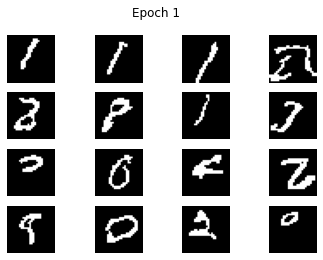

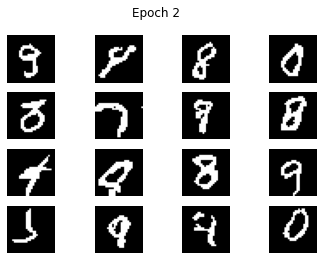

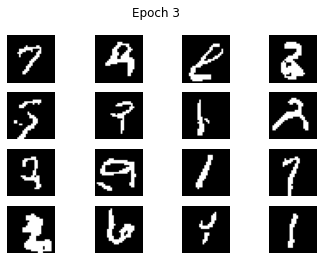

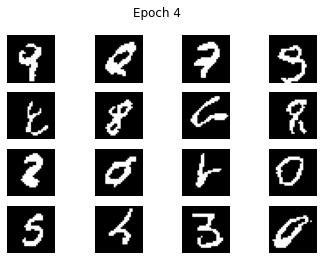

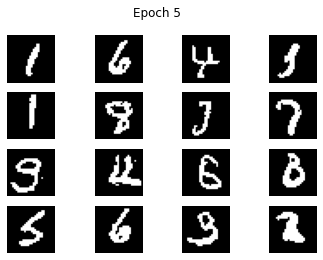

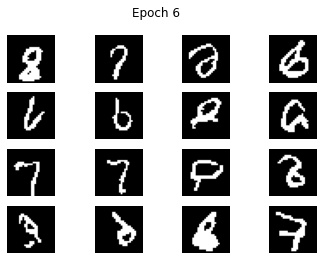

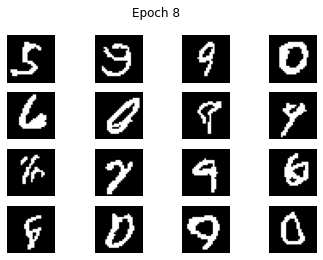

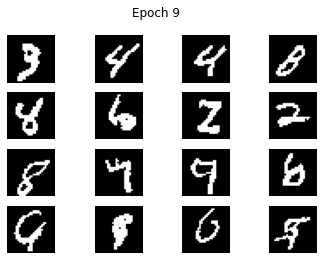

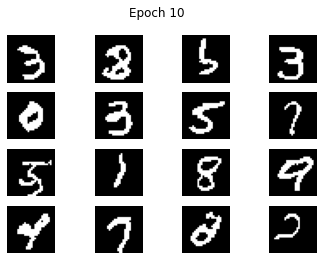

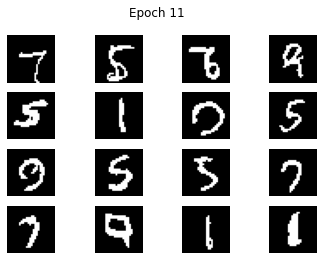

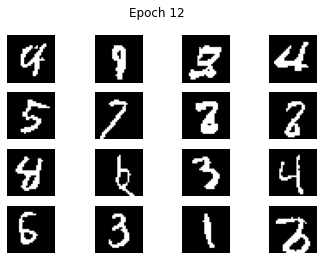

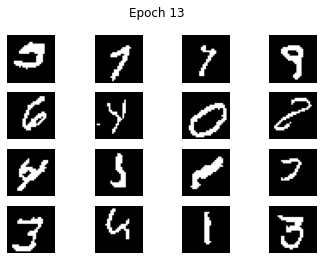

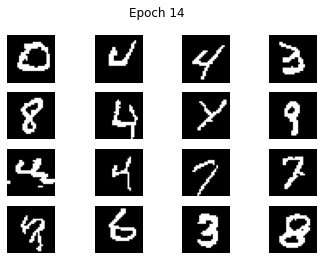

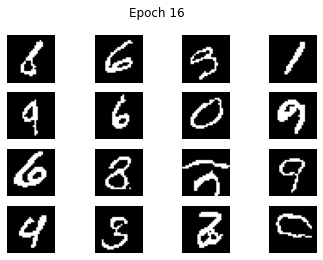

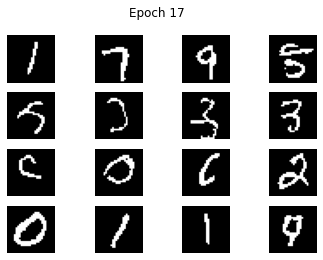

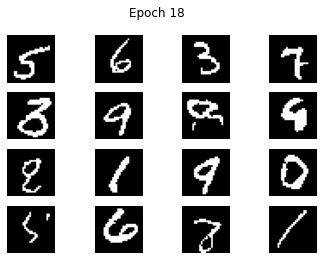

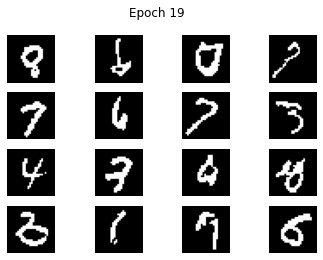

In [28]:
#training
nll_val = training(model, max_patience=max_patience, criterion=criterion, 
                   num_epochs=num_epochs, optimizer=optimizer, training_loader=training_loader, val_loader=testing_loader)

# WaveNet with conditional location embedding

In [29]:
model_loc = WaveNet("cuda",app_loc=True)
model_loc.to("cuda");

In [30]:
optimizer = torch.optim.AdamW([p for p in model_loc.parameters() if p.requires_grad==True], lr=lr)
criterion = nn.CrossEntropyLoss()

100%|██████████| 469/469 [00:35<00:00, 13.10it/s, loss=0.0934]


Epoch: 0, val nll=0.09416285355257083


100%|██████████| 469/469 [00:35<00:00, 13.13it/s, loss=0.0846]


Epoch: 1, val nll=0.08677259842051735


100%|██████████| 469/469 [00:35<00:00, 13.08it/s, loss=0.0832]


Epoch: 2, val nll=0.08294126212219649


100%|██████████| 469/469 [00:35<00:00, 13.09it/s, loss=0.082] 


Epoch: 3, val nll=0.08062207783702054


100%|██████████| 469/469 [00:36<00:00, 13.00it/s, loss=0.0777]


Epoch: 4, val nll=0.07925919792320155


100%|██████████| 469/469 [00:36<00:00, 13.01it/s, loss=0.0762]


Epoch: 5, val nll=0.07834199740539623


100%|██████████| 469/469 [00:36<00:00, 12.99it/s, loss=0.0765]


Epoch: 6, val nll=0.07773854696675192


100%|██████████| 469/469 [00:36<00:00, 12.94it/s, loss=0.0749]


Epoch: 7, val nll=0.07685645160418522


100%|██████████| 469/469 [00:36<00:00, 12.90it/s, loss=0.0734]


Epoch: 8, val nll=0.07659282007172138


100%|██████████| 469/469 [00:35<00:00, 13.03it/s, loss=0.0751]


Epoch: 9, val nll=0.07591610213246526


100%|██████████| 469/469 [00:36<00:00, 12.98it/s, loss=0.0753]


Epoch: 10, val nll=0.07588533349806749


100%|██████████| 469/469 [00:36<00:00, 13.02it/s, loss=0.0739]


Epoch: 11, val nll=0.07546013886038261


100%|██████████| 469/469 [00:36<00:00, 12.97it/s, loss=0.0712]


Epoch: 12, val nll=0.07517280203254917


100%|██████████| 469/469 [00:35<00:00, 13.09it/s, loss=0.0778]


Epoch: 13, val nll=0.0749926045536995


100%|██████████| 469/469 [00:36<00:00, 13.03it/s, loss=0.0735]


Epoch: 14, val nll=0.07484629335282725


100%|██████████| 469/469 [00:36<00:00, 13.01it/s, loss=0.0738]


Epoch: 15, val nll=0.07452558047032054


100%|██████████| 469/469 [00:35<00:00, 13.11it/s, loss=0.0755]


Epoch: 16, val nll=0.07461218809402442


100%|██████████| 469/469 [00:35<00:00, 13.03it/s, loss=0.0771]


Epoch: 17, val nll=0.07450005072581617


100%|██████████| 469/469 [00:35<00:00, 13.07it/s, loss=0.0709]


Epoch: 18, val nll=0.07429285856741893


100%|██████████| 469/469 [00:36<00:00, 13.01it/s, loss=0.0757]


Epoch: 19, val nll=0.074250885297226


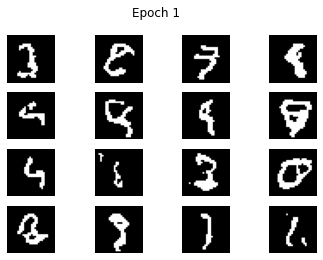

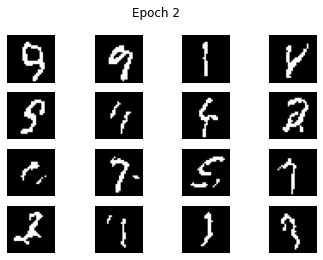

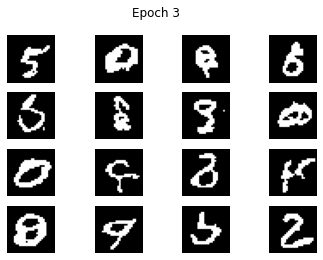

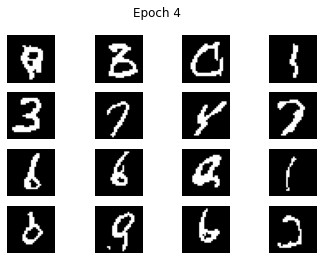

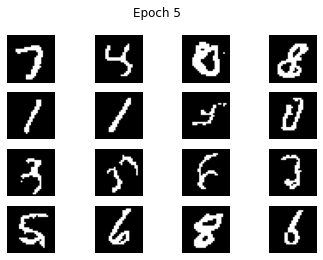

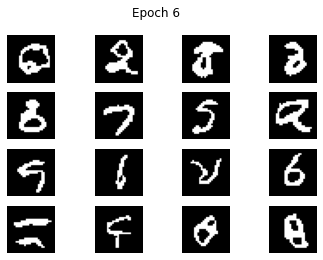

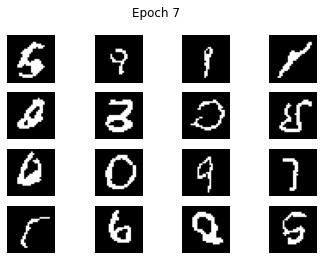

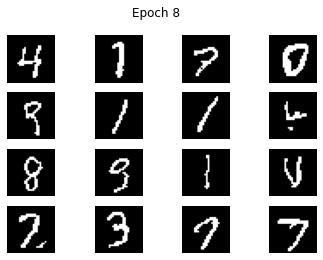

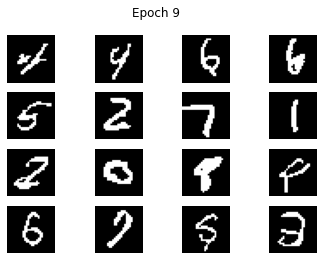

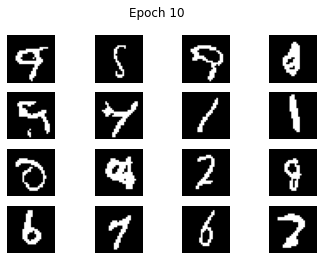

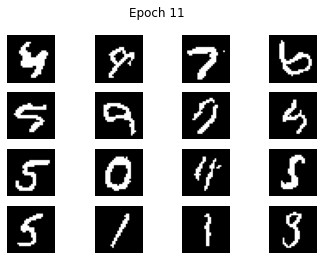

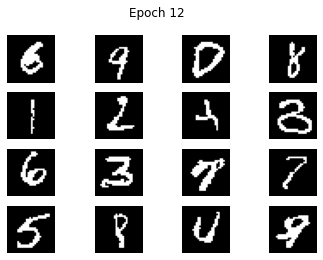

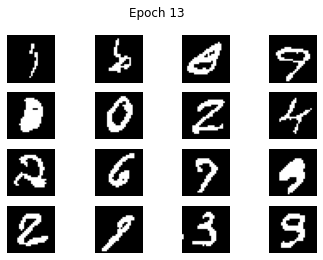

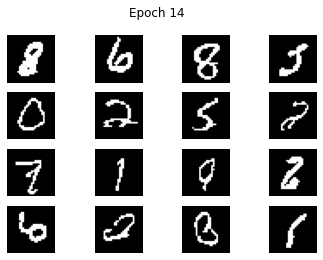

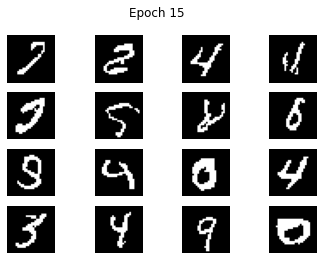

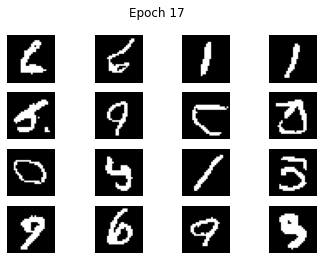

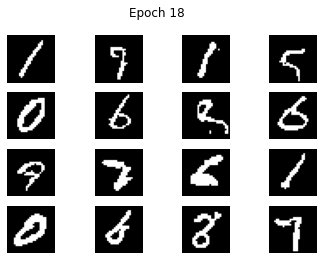

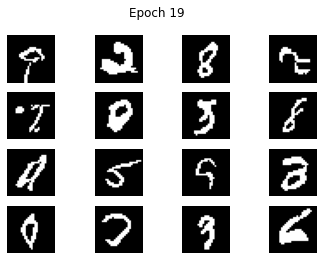

In [31]:
#training
nll_val = training(model_loc, max_patience=max_patience, criterion=criterion, 
                   num_epochs=num_epochs, optimizer=optimizer, training_loader=training_loader, val_loader=testing_loader)

In [32]:
torch.save(model.state_dict(),"wave_net_no_location_mnist.pth.tar")
torch.save(model_loc.state_dict(),"wave_net_location_mnist.pth.tar")